In [1]:
import numpy as np
from analyze_stability import * 
from scipy import linalg as LN
import math as m



### Parameter Setting:

#### Generator Parameter Setting
- $ T_{v} $ = Time constant of valve
- $ T_{e} $ = Time constant of engine
- $ H $ = Inertia Constant
- $ D $ = Fractional Constant

- $ M $ = $ 2\sum_i H_{i}$ 


In [2]:
Ts = 0.5*10**-4
wpu = 1.0;
Wmax = 1.02;

# Generator Parameter
Pgen = np.array([1, 1, 1])
droop = 0.05
Tv = np.array([0.5, 1.0, 1.0])
Te = np.array([0.05, 0.1, 0.1])
H = np.array([1.587, 2.5, 2.5])
D = 0.01
gen_dict = {'Sbase':150, 'Pgen':Pgen, 'droop':droop,
            'Tv':Tv, 'Te':Te, 'H':H, 'D':D}

# Control Parameter
con_dict = {'kp1': 8,
            'ki1': 2.5,
            'ki2': 5,
            'kc1' : 0.1,
            'Tl1' : 2.4
           }


### Generate System Matrix

In [3]:
# Ngen  number of generator
# Nval  number of variables for one generator
Ts = 0.5*10**-4
error_mat = np.array([0.0005, 0, -0.0005])

scenario = 'droop'
load_pattern = [90,110,110, 110]
case_dict = {'Ngen':3, 'Nval': cal_Nvariable(scenario), 'Ts': 0.5*10**-4, 'Ttotal': 200,
            'wpu':1.0, 'Wmax': 1.02, 'error': error_mat, 'input_flag': True, 'load_pattern': load_pattern}

A = generate_Amat(gen_dict, con_dict, case_dict, 'droop')
B = generate_Bmat(gen_dict, con_dict, case_dict)

### Analyze Eigen Value

In [4]:
eig,left_eig_v,right_eig_v = linalg.eig(A, left= True, right = True)

(-3.0, 3.0)

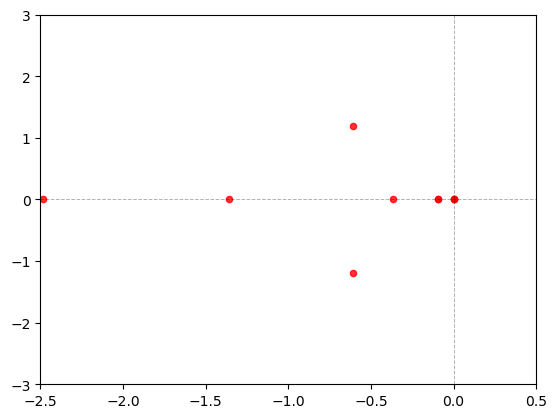

In [5]:
import matplotlib.pyplot as plt
plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
x = eig.real
y = eig.imag
plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
plt.xlim([-2.5, 0.5])
plt.ylim([ -3, 3])


### SDP for Lyapunov Function

In [6]:
import cvxpy as cp
import tabulate

### Inital Case
 ### case 1
 ### Minimize(0), A_T@P + P@A << 0
 

Matrix is symmetric
Eigen Value of P 
minimum eigenvalue of P: 0.0022917889106732524
maximum eigenvalue of P: 6.476692022615302


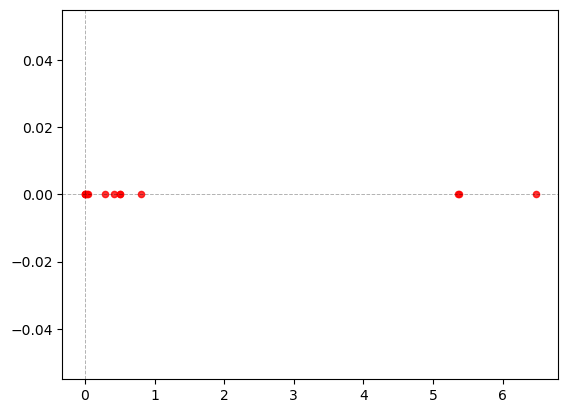

In [7]:
n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1e-6
G = np.eye(n)* gamma
# Define the constraints for the LMI

constraints = [P >> G, A.T @ P + P@A << 0 ]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options
#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK)


P_value = np.round(P.value, decimals=5)
eig,left_eig_v,right_eig_v = linalg.eig(P_value, left= True, right = True)
check_symmetric(P_value)

eig, eig_vec = linalg.eig(P_value)
print("Eigen Value of P ")
plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

x = eig.real
y = eig.imag

print("minimum eigenvalue of P:", min(x))
print("maximum eigenvalue of P:", max(x))


plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)



In [8]:
table = tabulate.tabulate(P.value, tablefmt='html')
print("symmetric P Table")
table

symmetric P Table


4.22698,0.643978,0.49452,-0.00384731,-1.66037,0.643992,0.286614,0.0145441,-1.28653,0.643992,0.286614,0.0145441,-1.28653
0.643978,0.226645,0.126913,0.000279805,-0.206355,0.222709,0.0603933,0.00764132,-0.194476,0.222709,0.0603933,0.00764133,-0.194476
0.49452,0.126913,0.568769,0.0057058,-0.795115,0.126895,-0.0618462,0.00902218,0.149663,0.126895,-0.0618464,0.00902222,0.149664
-0.00384731,0.000279805,0.0057058,0.00932113,-0.00314819,0.000279873,0.000695823,-0.00479354,0.00349634,0.000279873,0.00069581,-0.00479355,0.00349636
-1.66037,-0.206355,-0.795115,-0.00314819,4.51547,-0.284987,0.284906,-0.00599223,-0.917147,-0.284987,0.284906,-0.00599231,-0.917147
0.643992,0.222709,0.126895,0.000279873,-0.284987,0.226623,0.0604202,0.00764126,-0.116134,0.222732,0.0603863,0.00764141,-0.193972
0.286614,0.0603933,-0.0618462,0.000695823,0.284906,0.0604202,0.668988,0.0175688,-0.764466,0.0603863,-0.0295614,0.00368721,0.192341
0.0145441,0.00764132,0.00902218,-0.00479354,-0.00599223,0.00764126,0.0175688,0.038312,-0.0121733,0.0076414,0.00368724,-0.00918727,0.00354505
-1.28653,-0.194476,0.149663,0.00349634,-0.917147,-0.116134,-0.764466,-0.0121733,4.19699,-0.193972,0.192341,0.0035451,-0.968863
0.643992,0.222709,0.126895,0.000279873,-0.284987,0.222732,0.0603863,0.0076414,-0.193972,0.226623,0.0604202,0.00764127,-0.116134
0.286614,0.0603933,-0.0618464,0.00069581,0.284906,0.0603863,-0.0295614,0.00368724,0.192341,0.0604202,0.668988,0.0175688,-0.764466


In [9]:
Q = A.T@P.value + P.value@A
table1 = tabulate.tabulate(Q, tablefmt='html')
print("symmetric A.T@P+P@A Table")
table1

symmetric A.T@P+P@A Table


-0.689699,-0.171869,-0.077138,-0.11159,0.22947,-0.171876,-0.0950399,-0.121542,0.230974,-0.171876,-0.0950399,-0.121542,0.230974
-0.171869,-0.101438,0.0106596,-0.0477289,0.0511937,-0.101439,0.00122961,-0.0829829,0.0608443,-0.101439,0.0012296,-0.0829829,0.0608443
-0.077138,0.0106596,-0.305712,-0.0783051,0.31475,0.0106517,0.000283181,0.115289,-0.118859,0.0106517,0.000283292,0.115289,-0.118859
-0.11159,-0.0477289,-0.0783051,-0.398718,0.206259,-0.0477487,-0.00993967,0.167905,-0.0470949,-0.0477487,-0.0099394,0.167905,-0.0470953
0.22947,0.0511937,0.31475,0.206259,-0.629638,0.0512005,-0.0856566,-0.128534,0.199828,0.0512005,-0.0856568,-0.128534,0.199829
-0.171876,-0.101439,0.0106517,-0.0477487,0.0512005,-0.101439,0.00122793,-0.0829553,0.0608426,-0.101439,0.00122654,-0.0829907,0.0608461
-0.0950399,0.00122961,0.000283181,-0.00993967,-0.0856566,0.00122793,-0.294641,-0.0523878,0.283663,0.00122654,-0.00170383,0.0659652,-0.102979
-0.121542,-0.0829829,0.115289,0.167905,-0.128534,-0.0829553,-0.0523878,-0.807727,0.327241,-0.0829907,0.0659649,0.209494,-0.0763366
0.230974,0.0608443,-0.118859,-0.0470949,0.199828,0.0608426,0.283663,0.327241,-0.608664,0.0608461,-0.102979,-0.076337,0.177254
-0.171876,-0.101439,0.0106517,-0.0477487,0.0512005,-0.101439,0.00122654,-0.0829907,0.0608461,-0.101439,0.00122792,-0.0829552,0.0608426
-0.0950399,0.0012296,0.000283292,-0.0099394,-0.0856568,0.00122654,-0.00170383,0.0659649,-0.102979,0.00122792,-0.294641,-0.0523878,0.283663


A matrix change from droop to droop
Simulation Time: 40.871349573135376 secs
Draw the Frequency Plot
Draw the Active Power Plot


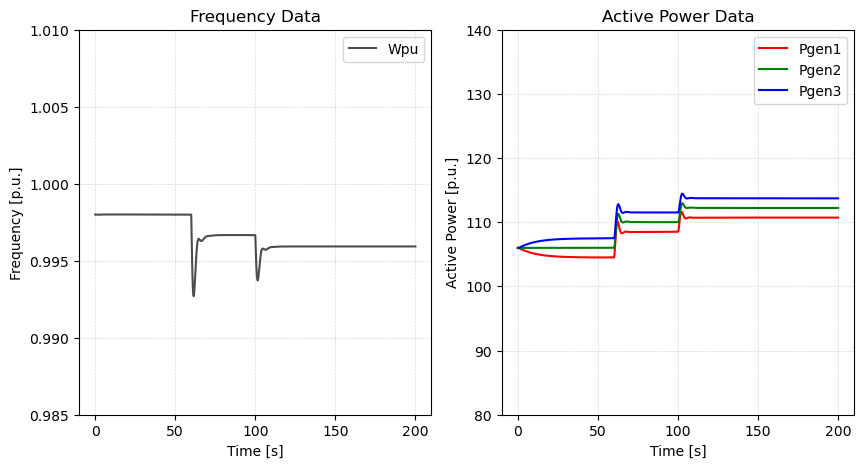

Lyapunov Simulation Time: 6.198014259338379 secs
Print_lyapunov_function for timeseries
Change A matrix from droop to the other set
Draw Lyapunov function
Draw the derivative of lyapunov function
Consider the input matrix


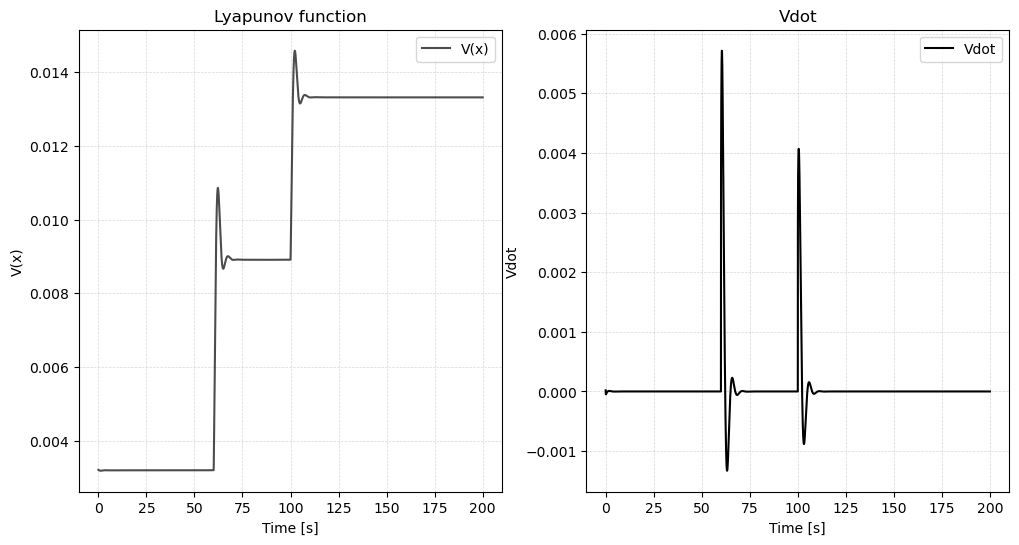

In [10]:
X_droop, U = run_timeseries(gen_dict, con_dict, case_dict, 'droop')

#Update Plot
draw_graph(X_droop, gen_dict, case_dict, scenario)

droop_set = {'X':X_droop, 'P':P.value, 'A_droop': A, 'A': A, 'B':B, 'U':U}
V_droop, V_dot_droop, V_input_dot_droop = draw_lyapunov(droop_set, case_dict)

### Case 2
### Minimize(cp.trace(P)), , A_T@P + P@A << 0

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 09 07:51:34 PM: Your problem has 169 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 09 07:51:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 09 07:51:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 07:51:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 09 07:51:34 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 09 07:51:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(CVXPY) Mar 09 07:51:34 PM: 24  1.7e-15  1.2e-16  1.5e-19  2.67e-01   3.304805679e-03   3.303200805e-03   1.1e-16  0.05  
(CVXPY) Mar 09 07:51:34 PM: 25  1.7e-15  3.2e-17  2.7e-20  5.53e-01   3.321307953e-03   3.320549230e-03   3.1e-17  0.05  
(CVXPY) Mar 09 07:51:34 PM: 26  6.6e-15  1.2e-17  9.7e-21  2.95e-01   3.333144879e-03   3.332390440e-03   1.1e-17  0.05  
(CVXPY) Mar 09 07:51:34 PM: 27  4.6e-15  3.6e-18  2.0e-21  6.24e-01   3.340072479e-03   3.339716522e-03   3.4e-18  0.05  
(CVXPY) Mar 09 07:51:34 PM: 28  7.8e-14  3.6e-18  2.0e-21  2.79e-01   3.340075395e-03   3.339719421e-03   3.4e-18  0.05  
(CVXPY) Mar 09 07:51:34 PM: 29  7.4e-14  3.6e-18  2.0e-21  2.79e-01   3.340076854e-03   3.339720872e-03   3.4e-18  0.06  
(CVXPY) Mar 09 07:51:34 PM: 30  9.2e-14  3.6e-18  2.0e-21  2.35e-01   3.340076877e-03   3.339720895e-03   3.4e-18  0.06  
(CVXPY) Mar 09 07:51:34 PM: 31  9.2e-14  3.6e-18  2.0e-21  2.35e-01   3.340076877e-03   3.339720895e-03   3.4e-18  0.06  
(CVXPY) Mar 09 07:51:34 

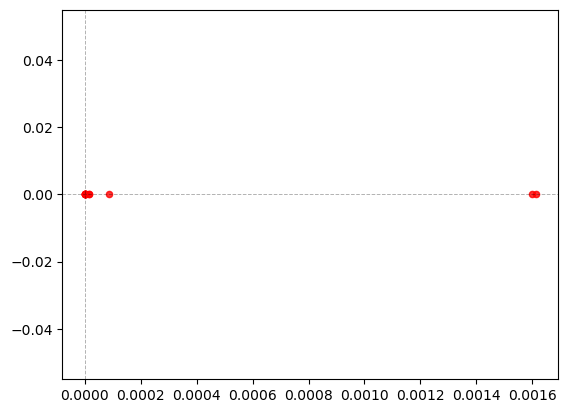

In [21]:
n = A.shape[0]

# Define the LMI variables
#P = cp.Variable((n,n), symmetric = True, PSD = True)
P = cp.Variable((n,n), symmetric = True)
gamma = 1.0* 1e-6
Q = np.eye(n)* gamma
# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P - 1e-6*np.eye(n)>> 0, A.T @ P + P@A << 0]

# Define the objective for the LMI optimization problem
obj = cp.Minimize(cp.trace(P))
#obj = cp.Minimize(cp.norm(P,1))

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK, verbose=True)

P_value = np.round(P.value, decimals=7)
eig,left_eig_v,right_eig_v = linalg.eig(P_value, left= True, right = True)
check_symmetric(P_value)

eig, eig_vec = linalg.eig(P_value)
print("Eigen Value of P ")
plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

x = eig.real
y = eig.imag

print("minimum eigenvalue of P:", min(x))
print("maximum eigenvalue of P:", max(x))


plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)



In [22]:
table = tabulate.tabulate(P_value, tablefmt='html')
print("symmetric P Table")
table

symmetric P Table


5.49e-05,1.24e-05,1.46e-05,3.8e-06,-3.16e-05,1.24e-05,4.6e-06,1.7e-06,-1.17e-05,1.24e-05,4.6e-06,1.7e-06,-1.17e-05
1.24e-05,4.7e-06,3.8e-06,9e-07,1.92e-05,2.7e-06,1.3e-06,4e-07,-1.57e-05,2.7e-06,1.3e-06,4e-07,-1.57e-05
1.46e-05,3.8e-06,1.6e-05,2.1e-06,-1.88e-05,3.8e-06,-2.1e-06,-6e-07,2.1e-06,3.8e-06,-2.1e-06,-6e-07,2.1e-06
3.8e-06,9e-07,2.1e-06,1.4e-06,-3.2e-06,9e-07,1e-07,0,-3e-07,9e-07,1e-07,0,-3e-07
-3.16e-05,1.92e-05,-1.88e-05,-3.2e-06,0.00109,-2.06e-05,1.7e-06,3e-07,-0.0005281,-2.06e-05,1.7e-06,3e-07,-0.0005281
1.24e-05,2.7e-06,3.8e-06,9e-07,-2.06e-05,4.7e-06,1.3e-06,4e-07,2.4e-05,2.7e-06,1.3e-06,4e-07,-1.57e-05
4.6e-06,1.3e-06,-2.1e-06,1e-07,1.7e-06,1.3e-06,1.03e-05,1.7e-06,-7.7e-06,1.3e-06,-2.5e-06,-2e-07,1.4e-06
1.7e-06,4e-07,-6e-07,0,3e-07,4e-07,1.7e-06,1.4e-06,-1.8e-06,4e-07,-2e-07,0,-2e-07
-1.17e-05,-1.57e-05,2.1e-06,-3e-07,-0.0005281,2.4e-05,-7.7e-06,-1.8e-06,0.0010699,-1.57e-05,1.4e-06,-2e-07,-0.0005279
1.24e-05,2.7e-06,3.8e-06,9e-07,-2.06e-05,2.7e-06,1.3e-06,4e-07,-1.57e-05,4.7e-06,1.3e-06,4e-07,2.4e-05
4.6e-06,1.3e-06,-2.1e-06,1e-07,1.7e-06,1.3e-06,-2.5e-06,-2e-07,1.4e-06,1.3e-06,1.03e-05,1.7e-06,-7.7e-06


In [23]:
Q = A.T@P_value + P_value@A
table1 = tabulate.tabulate(Q, tablefmt='html')
print("symmetric Q Table")
table1

symmetric Q Table


-0.000927824,-0.000218525,-0.000378394,-0.000208663,0.000684283,-0.000218525,-5.82031e-05,-4.90163e-05,0.000122315,-0.000218525,-5.82031e-05,-4.90163e-05,0.000122315
-0.000218525,-5.15561e-05,-8.92742e-05,-4.97179e-05,0.000161687,-5.15561e-05,-1.33037e-05,-1.14726e-05,2.85441e-05,-5.15561e-05,-1.33037e-05,-1.14726e-05,2.85441e-05
-0.000378394,-8.92742e-05,-0.00022572,-0.00010754,0.0003539,-8.92842e-05,7.71e-06,4.885e-06,1.2505e-05,-8.92842e-05,7.71e-06,4.885e-06,1.2505e-05
-0.000208663,-4.97179e-05,-0.00010754,-5.74e-05,0.0001916,-4.97179e-05,-3.385e-06,-5e-07,8.7e-06,-4.97179e-05,-3.385e-06,-5e-07,8.7e-06
0.000684283,0.000161687,0.0003539,0.0001916,-0.00064,0.000161687,1.1605e-05,-1.6e-06,-2.25e-05,0.000161687,1.1605e-05,-1.6e-06,-2.25e-05
-0.000218525,-5.15561e-05,-8.92842e-05,-4.97179e-05,0.000161687,-5.15561e-05,-1.32887e-05,-1.14726e-05,2.85441e-05,-5.15561e-05,-1.33037e-05,-1.14726e-05,2.85441e-05
-5.82031e-05,-1.33037e-05,7.71e-06,-3.385e-06,1.1605e-05,-1.32887e-05,-4.423e-05,-2.751e-05,3.8205e-05,-1.33037e-05,8.06e-06,1.1e-07,8.495e-06
-4.90163e-05,-1.14726e-05,4.885e-06,-5e-07,-1.6e-06,-1.14726e-05,-2.751e-05,-2.74e-05,4.71e-05,-1.14726e-05,1.1e-07,-4e-07,3.6e-06
0.000122315,2.85441e-05,1.2505e-05,8.7e-06,-2.25e-05,2.85441e-05,3.8205e-05,4.71e-05,-9e-05,2.85441e-05,8.495e-06,3.6e-06,-1e-05
-0.000218525,-5.15561e-05,-8.92842e-05,-4.97179e-05,0.000161687,-5.15561e-05,-1.33037e-05,-1.14726e-05,2.85441e-05,-5.15561e-05,-1.32887e-05,-1.14726e-05,2.85441e-05
-5.82031e-05,-1.33037e-05,7.71e-06,-3.385e-06,1.1605e-05,-1.33037e-05,8.06e-06,1.1e-07,8.495e-06,-1.32887e-05,-4.423e-05,-2.751e-05,3.8205e-05


A matrix change from droop to droop
Simulation Time: 41.951478719711304 secs
Draw the Frequency Plot
Draw the Active Power Plot


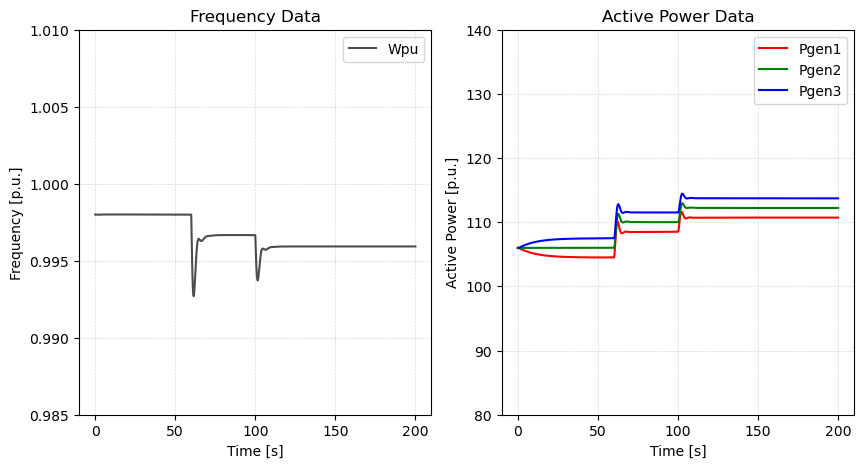

Lyapunov Simulation Time: 6.415975570678711 secs
Print_lyapunov_function for timeseries
Change A matrix from droop to the other set
Draw Lyapunov function
Draw the derivative of lyapunov function
Consider the input matrix


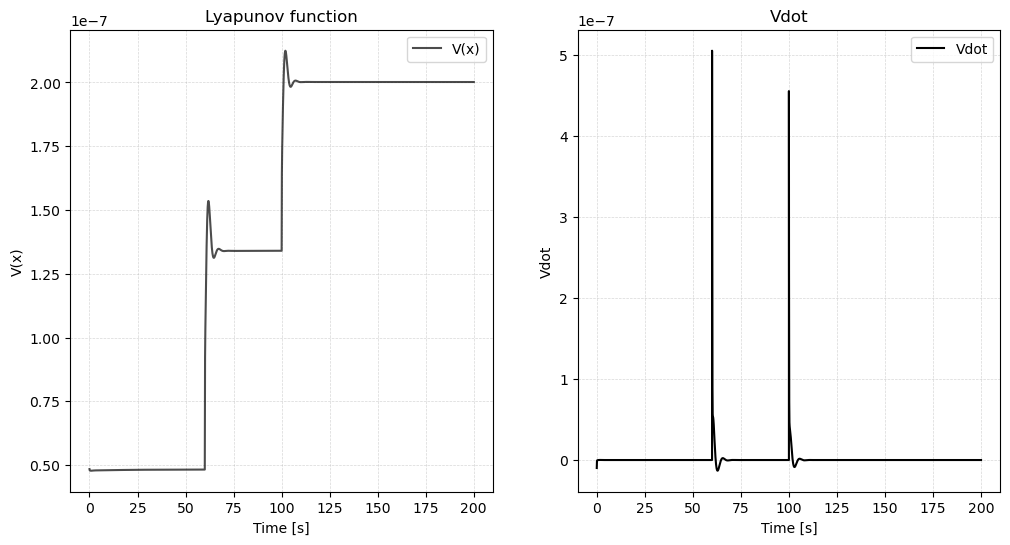

In [24]:
X_droop, U = run_timeseries(gen_dict, con_dict, case_dict, 'droop')

#Update Plot
draw_graph(X_droop, gen_dict, case_dict, scenario)

droop_set = {'X':X_droop, 'P':P_value, 'A_droop': A, 'A': A, 'B':B, 'U':U}
V_droop, V_dot_droop, V_input_dot_droop = draw_lyapunov(droop_set, case_dict)

In [18]:
table = tabulate.tabulate(P_value, tablefmt='html')
print("symmetric P Table")
table

symmetric P Table


6.1e-05,1.5e-05,1.4e-05,3e-06,-3.4e-05,1.5e-05,4e-06,2e-06,-1.4e-05,1.5e-05,4e-06,2e-06,-1.4e-05
1.5e-05,7e-06,4e-06,1e-06,4.4e-05,5e-06,1e-06,1e-06,1e-05,5e-06,1e-06,1e-06,1e-05
1.4e-05,4e-06,2.9e-05,1e-06,-1.6e-05,4e-06,-7e-06,-0,1e-06,4e-06,-7e-06,-0,1e-06
3e-06,1e-06,1e-06,1e-06,-3e-06,1e-06,0,-0,-0,1e-06,0,-0,-0
-3.4e-05,4.4e-05,-1.6e-05,-3e-06,0.001603,5e-06,0,-0,-0,5e-06,0,-0,-0
1.5e-05,5e-06,4e-06,1e-06,5e-06,7e-06,1e-06,1e-06,5e-05,5e-06,1e-06,1e-06,1.1e-05
4e-06,1e-06,-7e-06,0,0,1e-06,2.1e-05,0,-3e-06,1e-06,-6e-06,0,-0
2e-06,1e-06,-0,-0,-0,1e-06,0,1e-06,-2e-06,1e-06,0,0,-0
-1.4e-05,1e-05,1e-06,-0,-0,5e-05,-3e-06,-2e-06,0.001615,1.1e-05,-0,-0,3e-06
1.5e-05,5e-06,4e-06,1e-06,5e-06,5e-06,1e-06,1e-06,1.1e-05,7e-06,1e-06,1e-06,5e-05
4e-06,1e-06,-7e-06,0,0,1e-06,-6e-06,0,-0,1e-06,2.1e-05,0,-3e-06


### Case 3
### Minimize(cp.trace(P)), , A_T@P + P@A + Q << 0
#### Q -> cp variable

Matrix is symmetric
Matrix is symmetric
Eigen Value of P 
minimum eigenvalue of P: 0.0
maximum eigenvalue of P: 0.0


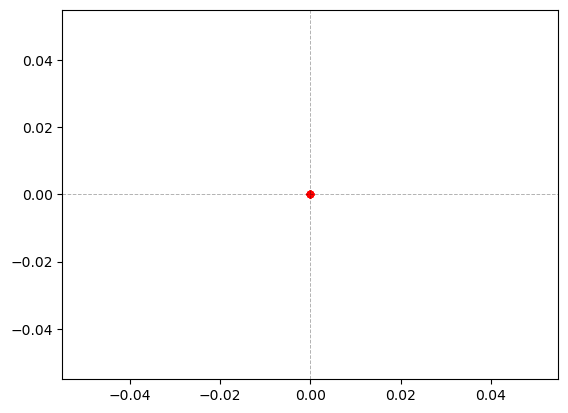

In [22]:
n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1.0* 1e-6
Q = np.eye(n)* gamma
Q = cp.Variable((n,n), symmetric = True)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >>0, Q >>0, A.T @ P + P@A + Q << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(cp.trace(P))

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK)

P_value = np.round(P.value, decimals=5)
Q_value = np.round(Q.value, decimals=5)
eig,left_eig_v,right_eig_v = linalg.eig(P_value, left= True, right = True)
check_symmetric(P_value)
check_symmetric(Q_value)

eig, eig_vec = linalg.eig(P_value)
print("Eigen Value of P ")
plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

x = eig.real
y = eig.imag

print("minimum eigenvalue of P:", min(x))
print("maximum eigenvalue of P:", max(x))


plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)



In [13]:
table = tabulate.tabulate(Q.value, tablefmt='html')
print("symmetric Q Table")
table

symmetric Q Table


2.34083e-06,5.70943e-07,1.20257e-06,5.10949e-07,-2.23125e-06,-1.49911e-21,5.60039e-07,4.12246e-08,4.94421e-08,-1.1493e-07,6.00211e-24
5.70943e-07,1.3915e-07,2.97973e-07,1.249e-07,-5.43197e-07,-3.44739e-22,1.3648e-07,1.05444e-08,1.21196e-08,-2.87748e-08,1.66164e-24
1.20257e-06,2.97973e-07,6.25343e-07,2.69116e-07,-1.16074e-06,-7.90958e-22,2.87569e-07,1.34209e-08,2.26989e-08,-4.49747e-08,2.74129e-24
5.10949e-07,1.249e-07,2.69116e-07,1.06384e-07,-4.95655e-07,-3.01898e-22,1.21993e-07,3.45394e-09,7.88572e-09,-1.64936e-08,2.15514e-24
-2.23125e-06,-5.43197e-07,-1.16074e-06,-4.95655e-07,2.15728e-06,1.62472e-21,-5.33895e-07,-2.39356e-08,-4.05152e-08,7.94767e-08,-4.05201e-24
-1.49911e-21,-3.44739e-22,-7.90958e-22,-3.01898e-22,1.62472e-21,-1.81837e-20,-4.13136e-22,3.56917e-23,6.48847e-23,-1.10797e-22,2.66053e-22
5.60039e-07,1.3648e-07,2.87569e-07,1.21993e-07,-5.33895e-07,-4.13136e-22,1.3381e-07,1.39516e-08,1.20476e-08,-2.71474e-08,1.51335e-24
4.12246e-08,1.05444e-08,1.34209e-08,3.45394e-09,-2.39356e-08,3.56917e-23,1.39516e-08,9.63648e-09,8.22541e-09,-1.72161e-08,7.04079e-25
4.94421e-08,1.21196e-08,2.26989e-08,7.88572e-09,-4.05152e-08,6.48847e-23,1.20476e-08,8.22541e-09,4.39667e-10,-8.87929e-09,1.37894e-24
-1.1493e-07,-2.87748e-08,-4.49747e-08,-1.64936e-08,7.94767e-08,-1.10797e-22,-2.71474e-08,-1.72161e-08,-8.87929e-09,3.53154e-08,-1.99096e-24
6.00211e-24,1.66164e-24,2.74129e-24,2.15514e-24,-4.05201e-24,2.66053e-22,1.51335e-24,7.04079e-25,1.37894e-24,-1.99096e-24,-2.23963e-23


### Case 4
### Minimize(cp.trace(P)), , A_T@P + P@A + Q << 0
#### Q -> eye(n)

In [44]:
n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1.0
Q = np.eye(n)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >>0, A.T @ P + P@A + Q << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(cp.trace(P))

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
sol = prob.solve(solver=cp.MOSEK)

if not m.isinf(sol):
    P_value = np.round(P.value, decimals=5)
    eig,left_eig_v,right_eig_v = linalg.eig(P_value, left= True, right = True)
    check_symmetric(P_value)

    eig, eig_vec = linalg.eig(P_value)
    print("Eigen Value of P ")
    plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
    plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

    x = eig.real
    y = eig.imag

    print("minimum eigenvalue of P:", min(x))
    print("maximum eigenvalue of P:", max(x))

    plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
else:
    print("Infinitity Solution - cannot solved")


Infinitity Solution - cannot solved


### Case 5
### Minimize(0),  A_T@P + P@A + Q << 0
#### Q -> eye(n)

In [46]:
n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1.0
Q = np.eye(n)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >>0, A.T @ P + P@A + Q << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
sol = prob.solve(solver=cp.MOSEK)

if not m.isinf(sol):
    P_value = np.round(P.value, decimals=5)
    eig,left_eig_v,right_eig_v = linalg.eig(P_value, left= True, right = True)
    check_symmetric(P_value)

    eig, eig_vec = linalg.eig(P_value)
    print("Eigen Value of P ")
    plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
    plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

    x = eig.real
    y = eig.imag

    print("minimum eigenvalue of P:", min(x))
    print("maximum eigenvalue of P:", max(x))

    plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
else:
    print("Infinitity Solution - cannot solved")


Infinitity Solution - cannot solved


### Case 6
### Minimize(0),  A_T@P + P@A + r*Q << 0
#### Try to find gaama that converged, Q -> eye(n)

In [11]:
n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1.0
Q = np.eye(n)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >>0, A.T @ P + P@A + Q << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
sol = prob.solve(solver=cp.MOSEK)

iter = 0
prev_iter = 0
now_iter = 0
while True:
    
    if not m.isinf(sol):
        break
    try:
        now_iter = iter
        n_niter = len(str(now_iter)) 
        n_piter = len(str(prev_iter))
        if n_niter - n_piter > 0:
            print('*'*n_niter)

        prev_iter = now_iter

        gamma -= 0.000001
        if gamma <= 0:
            print("gamma goes to zero")
            break

        constraints = [P >>0, A.T @ P + P@A + gamma*Q << 0]
        prob = cp.Problem(obj, constraints)    
        sol = prob.solve(solver=cp.MOSEK)

        iter += 1
    except:
        print('gamma:',gamma)
        print('Cannot Solved')
        break
print("iteration:", iter)
    
if not m.isinf(sol):
    P_value = np.round(P.value, decimals=5)
    eig,left_eig_v,right_eig_v = linalg.eig(P_value, left= True, right = True)
    check_symmetric(P_value)

    eig, eig_vec = linalg.eig(P_value)
    print("Eigen Value of P ")
    plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
    plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

    x = eig.real
    y = eig.imag

    print("minimum eigenvalue of P:", min(x))
    print("maximum eigenvalue of P:", max(x))

    plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
else:
    print("Infinitity Solution - cannot solved")


**
***
****
*****
******
gamma: 0.3075539999907712
Cannot Solved
iteration: 692445
Infinitity Solution - cannot solved


In [10]:
n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1.0
Q = np.eye(n)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >>0, A.T @ P + P@A + 0.00213899 * Q << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
sol = prob.solve(solver=cp.MOSEK)



Print_lyapunov_function for timeseries


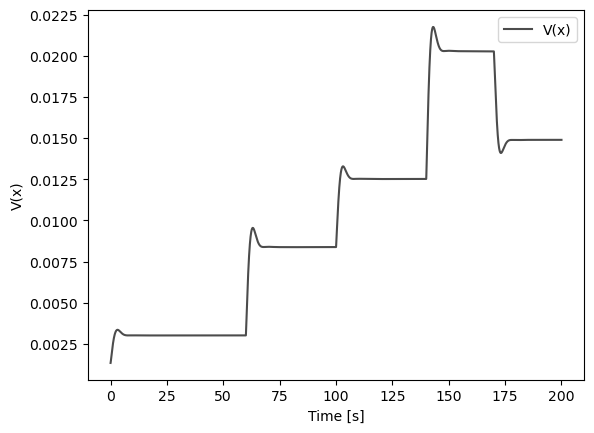

In [55]:
print("Print_lyapunov_function for timeseries")

nTime = X_droop.shape[1]
x = np.arange(nTime)*Ts 
V = np.zeros([nTime]) 

P_value = P.value
for i in range(nTime):
    temp = np.dot(X_droop[:,i].T, P_value)
    V[i] = np.dot(temp, X_droop[:,i])

plt.plot(x,V, label='V(x)', color = 'black', alpha = 0.7)
plt.legend(loc='best', fontsize=10)
plt.ylabel('V(x)')
plt.xlabel('Time [s]')
plt.show()

### Case 7
### Secondary PI System
### Minimize(0),  A_T@P + P@A << 0

(-3.0, 3.0)

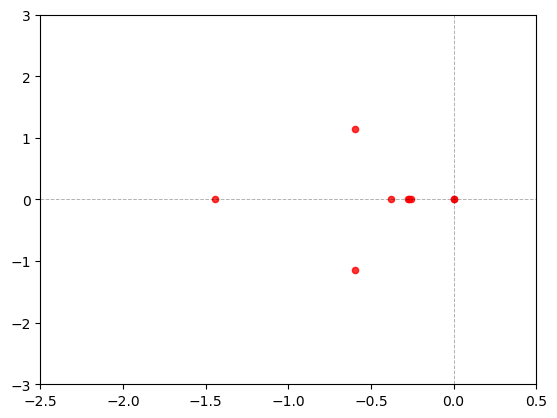

In [21]:
A = generate_Amat(gen_dict, con_dict, case_dict, 'secondPI')
eig,left_eig_v,right_eig_v = linalg.eig(A, left= True, right = True)

plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
x = eig.real
y = eig.imag
plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
plt.xlim([-2.5, 0.5])
plt.ylim([ -3, 3])

Matrix is symmetric
Eigen Value of P 
minimum eigenvalue of P: 0.010303063636250973
maximum eigenvalue of P: 6.202763445845726


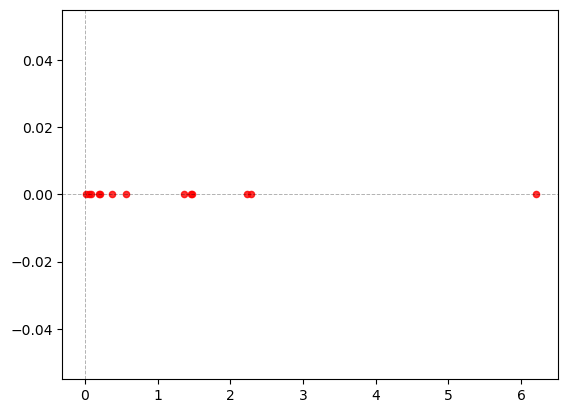

In [11]:
Ts = 0.5*10**-4

A_droop = generate_Amat(gen_dict, con_dict, case_dict, 'droop')
A = generate_Amat(gen_dict, con_dict, case_dict, 'secondPI')
n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1e-6
G = np.eye(n)* gamma
# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >> G, A.T @ P + P@A << 0 ]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK)

P_value = np.round(P.value, decimals=5)
eig,left_eig_v,right_eig_v = linalg.eig(P_value, left= True, right = True)
check_symmetric(P_value)

eig, eig_vec = linalg.eig(P_value)
print("Eigen Value of P ")
plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

x = eig.real
y = eig.imag

print("minimum eigenvalue of P:", min(x))
print("maximum eigenvalue of P:", max(x))


plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)


A matrix change from droop to secondPI
Simulation Time: 41.08859992027283 secs
Draw the Frequency Plot
Draw the Active Power Plot


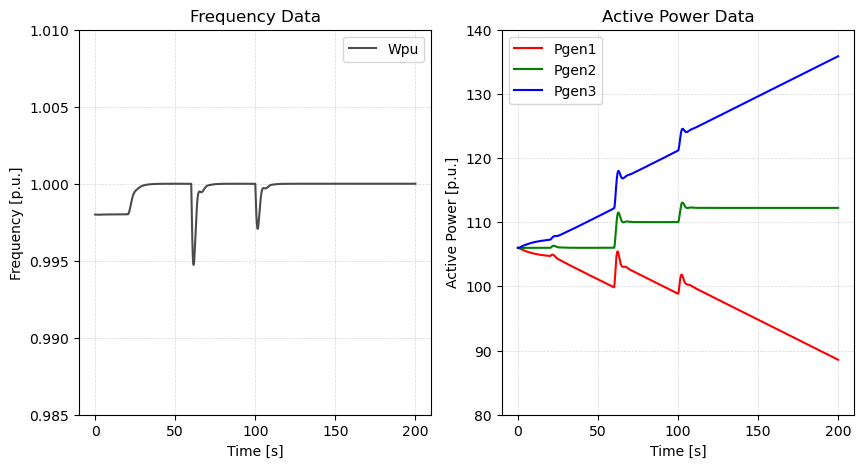

Lyapunov Simulation Time: 8.726617097854614 secs
Print_lyapunov_function for timeseries
Change A matrix from droop to the other set
Draw Lyapunov function
Draw the derivative of lyapunov function
Consider the input matrix


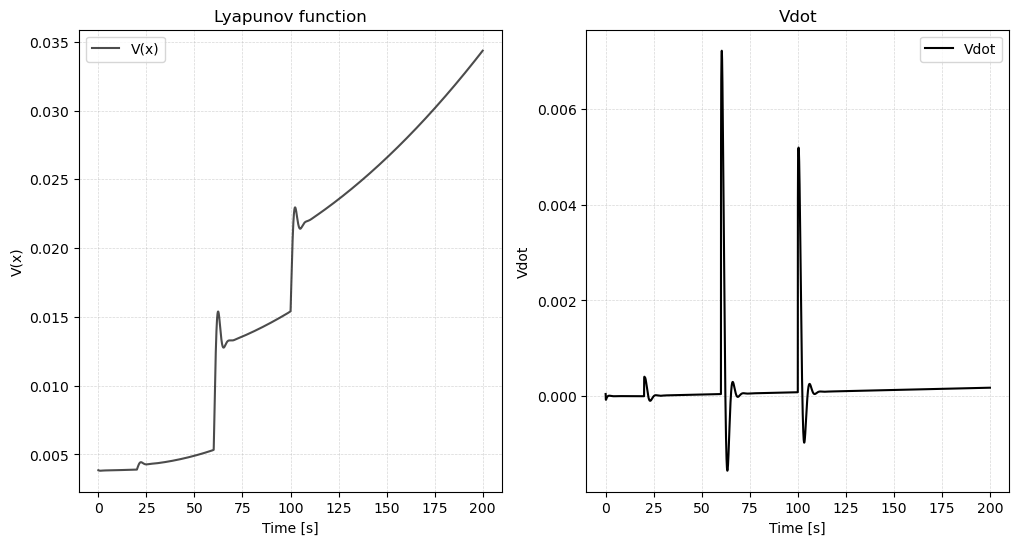

In [12]:
X_secPI, U = run_timeseries(gen_dict, con_dict, case_dict, 'secondPI')

#Update Plot
draw_graph(X_secPI, gen_dict, case_dict, scenario)

A_droop = generate_Amat(gen_dict, con_dict, case_dict, 'droop')
A = generate_Amat(gen_dict, con_dict, case_dict, 'secondPI')
second_PI_set = {'X':X_secPI, 'P':P.value, 'A_droop': A_droop, 'A': A, 'B':B,
                'U': U}
V_secPI, V_dot_secPI, V_input_dot_secPI = draw_lyapunov(second_PI_set, case_dict)

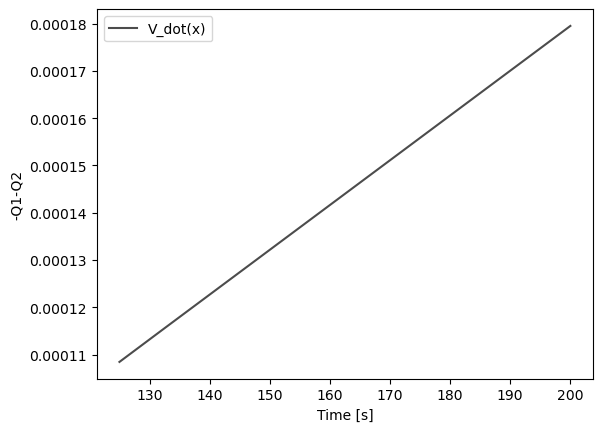

In [33]:

x = np.arange(200/Ts)*Ts 

plt.plot(x[2500000:],V_input_dot_secPI[2500000:] + V_dot_secPI[2500000:], label='V_dot(x)', color = 'black', alpha = 0.7)
plt.legend(loc='best', fontsize=10)
plt.ylabel('-Q1-Q2')
plt.xlabel('Time [s]')
plt.show()

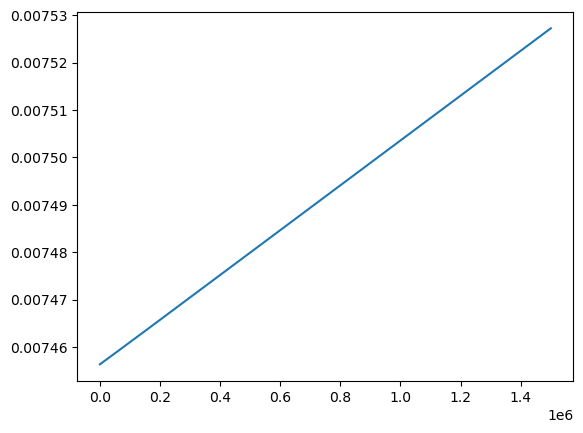

In [20]:

x = np.arange(200/Ts)*Ts 

plt.plot(x,V_dot_secPI, label='V_dot(x)', color = 'black', alpha = 0.7)
plt.legend(loc='best', fontsize=10)
plt.ylabel('-Q1')
plt.xlabel('Time [s]')
plt.show()

In [16]:
V_input_dot_secPI.shape

(4000000,)

### Case 8
### Secondary PI System
### Minimize(0),  A_T@P + P@A + 2PBU << 0

In [66]:
A = generate_Amat(gen_dict, con_dict, case_dict, 'droop')
B = generate_Bmat(gen_dict, con_dict, case_dict)

n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1e-6
Q = np.eye(n)* gamma

U = np.array([0.05, 0.0005, -0.0005]).T

bias = LN.norm(np.dot(B,U),2)*2*0.05

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >> Q, A.T @ P + P@A + 2*bias*P  << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK, verbose = True)

P_value = np.round(P.value, decimals=5)
eig,left_eig_v,right_eig_v = LN.eig(P_value, left= True, right = True)
check_symmetric(P_value)

eig, eig_vec = LN.eig(P_value)
print("Eigen Value of P ")
plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

x = eig.real
y = eig.imag

print("minimum eigenvalue of P:", min(x))
print("maximum eigenvalue of P:", max(x))


plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)



                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 09 03:49:39 PM: Your problem has 81 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 09 03:49:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 09 03:49:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 03:49:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 09 03:49:39 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 09 03:49:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

### Case 9
### Proposed Control
### Minimize(0),  A_T@P + P@A << 0

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 09 10:18:50 PM: Your problem has 361 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 09 10:18:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 09 10:18:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 10:18:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 09 10:18:50 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 09 10:18:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

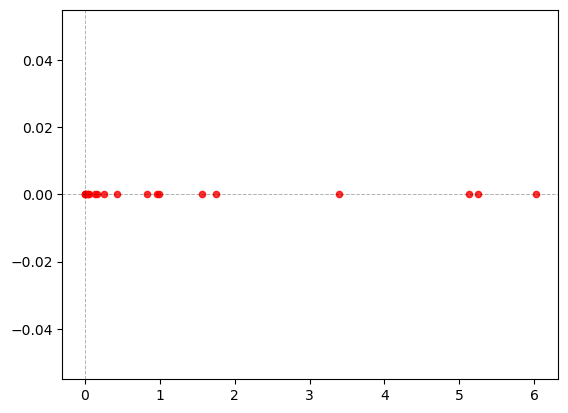

In [36]:
scenario = 'nudge'
case_dict['Nval'] = cal_Nvariable(scenario)
A = generate_Amat(gen_dict, con_dict, case_dict, 'nudge')
#B = generate_Bmat(gen_dict, con_dict, case_dict)

n = A.shape[0]

# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma = 1e-6
Q = np.eye(n)* gamma

U = np.array([0.05, 0.0005, -0.0005]).T

#bias = LN.norm(np.dot(B,U),2)*2*0.05

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]
constraints = [P >> Q, A.T @ P + P@A << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK, verbose = True)

P_value = np.round(P.value, decimals=5)
eig,left_eig_v,right_eig_v = LN.eig(P_value, left= True, right = True)
check_symmetric(P_value)

eig, eig_vec = LN.eig(P_value)
print("Eigen Value of P ")
plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

x = eig.real
y = eig.imag

print("minimum eigenvalue of P:", min(x))
print("maximum eigenvalue of P:", max(x))


plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)



### Case 10
### droop System
### Bound RMS Methods

In [59]:
A = generate_Amat(gen_dict, con_dict, case_dict, 'droop')
B = generate_Bmat(gen_dict, con_dict, case_dict)
B = B/100000
n = A.shape[0]
m = B.shape[1]
# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma2 = cp.Variable()
Q = np.eye(n)
C = np.array([0, 1, 0, 0, 0, 1, 0, 0, 0])

U = np.array([0.05, 0.0005, -0.0005]).T

bias = LN.norm(np.dot(B,U),2)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]

M = cp.bmat([[A.T @ P + P@A +C.T@C, P@B], [B.T@P, -gamma2*np.eye(m)]])
constraints = [P >> 1e-6*np.eye(n), M <<0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK, verbose = True)

try:
    P_value = np.round(P.value, decimals=5)
    eig,left_eig_v,right_eig_v = LN.eig(P_value, left= True, right = True)
    check_symmetric(P_value)

    eig, eig_vec = LN.eig(P_value)
    print("Eigen Value of P ")
    plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
    plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

    x = eig.real
    y = eig.imag

    print("minimum eigenvalue of P:", min(x))
    print("maximum eigenvalue of P:", max(x))


    plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
except:
    print("Solution Infeasible")


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 09 03:45:44 PM: Your problem has 82 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 09 03:45:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 09 03:45:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 03:45:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 09 03:45:44 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 09 03:45:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

### Case 11
### Switched System
### Common Lyapunov

In [16]:
A_droop = generate_Amat(gen_dict, con_dict, case_dict, 'droop')
A_secPI = generate_Amat(gen_dict, con_dict, case_dict, 'secPI')
B = generate_Bmat(gen_dict, con_dict, case_dict)

n = A.shape[0]
m = B.shape[1]
# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma2 = cp.Variable()
Q = np.eye(n)*1e-6
C = np.array([0, 1, 0, 0, 0, 1, 0, 0, 0])

U = np.array([0.05, 0.0005, -0.0005]).T

bias = LN.norm(np.dot(B,U),2)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]

constraints = [P >> 0,  A_droop.T @ P + P@A_droop - P @B @ B.T @ P + Q << 0 ]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK, verbose = True)

try:
    P_value = np.round(P.value, decimals=5)
    eig,left_eig_v,right_eig_v = LN.eig(P_value, left= True, right = True)
    check_symmetric(P_value)

    eig, eig_vec = LN.eig(P_value)
    print("Eigen Value of P ")
    plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
    plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

    x = eig.real
    y = eig.imag

    print("minimum eigenvalue of P:", min(x))
    print("maximum eigenvalue of P:", max(x))


    plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
except:
    print("Solution Infeasible")


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 09 05:26:38 PM: Your problem has 169 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 09 05:26:38 PM: It is compliant with the following grammars: 
(CVXPY) Mar 09 05:26:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 05:26:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
Promote(0.0, (13, 13)) + -[[-7.59070897e-04  0.00000000e+00  0.00000000e+00 -9.97570973e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.49392743e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.59070897e-02  0.00000000e+00  0.00000000e+00 -2.42902687e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -6.07256718e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.60000000e+01
  -5.00000000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -2.20000000e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.59070897e-02  0.00000000e+00  0.00000000e+00 -2.42902687e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -6.07256718e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00 -1.40000000e+01 -5.00000000e-02  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00 -1.10000000e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.50000000e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]] @ var127 + var127 @ [[-7.59070897e-04  7.59070897e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.59070897e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.97570973e+01 -2.42902687e+01 -5.60000000e+01 -2.20000000e+01
   1.00000000e+02  0.00000000e+00  0.00000000e+00 -2.42902687e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.00000000e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.49392743e+01 -6.07256718e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.07256718e+00
  -1.40000000e+01 -1.10000000e+01  2.50000000e+01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.00000000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]] + -var127 @ [[-7.59070897e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42902687e+01 -1.00000000e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.07256718e+00  0.00000000e+00 -2.50000000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]] @ [[-7.59070897e-02  0.00000000e+00  0.00000000e+00  2.42902687e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  6.07256718e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.50000000e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]] @ var127 + [[1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06
  0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
  0.e+00 0.e+00 1.e-06]] >> 0 , because the following subexpressions are not:
|--  var127 @ [[-7.59070897e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42902687e+01 -1.00000000e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.07256718e+00  0.00000000e+00 -2.50000000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]] @ [[-7.59070897e-02  0.00000000e+00  0.00000000e+00  2.42902687e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  6.07256718e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.50000000e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]] @ var127

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 09 05:19:35 PM: Your problem has 169 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 09 05:19:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 09 05:19:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 05:19:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 09 05:19:35 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 09 05:19:35 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

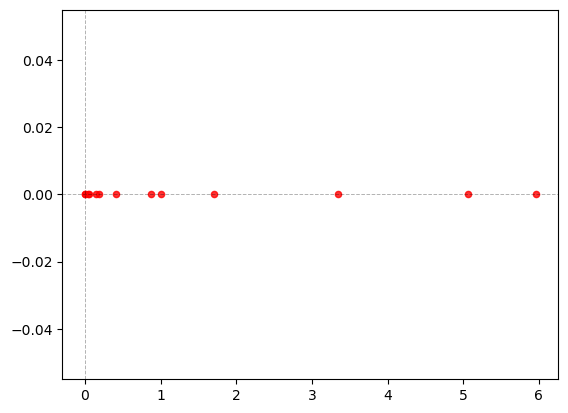

In [11]:
scenario = 'nudge'
case_dict['Nval'] = cal_Nvariable(scenario)
A = generate_Amat(gen_dict, con_dict, case_dict, scenario)
A_secPI = generate_Amat(gen_dict, con_dict, case_dict, 'secPI')
A_droop = generate_Amat(gen_dict, con_dict, case_dict, 'droop')

n = A.shape[0]
m = B.shape[1]
# Define the LMI variables
P = cp.Variable((n,n), symmetric = True)
gamma2 = cp.Variable()
Q = np.eye(n)*1e-6
C = np.array([0, 1, 0, 0, 0, 1, 0, 0, 0])

U = np.array([0.05, 0.0005, -0.0005]).T

bias = LN.norm(np.dot(B,U),2)

# Define the constraints for the LMI
#constraints = [P >>0, A.T @ P + P@A + Q << 0]

constraints = [P >> Q,  A.T @ P + P@A << 0]

# Define the objective for the LMI optimization problem
#obj = cp.Minimize(cp.trace(P))
obj = cp.Minimize(0)

# Solve the LMI optimization problem
prob = cp.Problem(obj, constraints)

# Create a SolverOptions object and set the tolerance to 1e-6
# Solve the problem with the specified options

#prob.solve(solver=cp.MOSEK, verbose=True) #, options=options)
prob.solve(solver=cp.MOSEK, verbose = True)

try:
    P_value = np.round(P.value, decimals=5)
    eig,left_eig_v,right_eig_v = LN.eig(P_value, left= True, right = True)
    check_symmetric(P_value)

    eig, eig_vec = LN.eig(P_value)
    print("Eigen Value of P ")
    plt.axvline(x=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')
    plt.axhline(y=0, color = 'black', alpha = 0.3, linewidth = 0.7, linestyle='--')

    x = eig.real
    y = eig.imag

    print("minimum eigenvalue of P:", min(x))
    print("maximum eigenvalue of P:", max(x))


    plt.scatter(x,y, s = 20, c = 'r', alpha = 0.8)
except:
    print("Solution Infeasible")


In [14]:
Q = A.T@P.value + P.value@A
check_symmetric(Q)
table1 = tabulate.tabulate(Q, tablefmt='html')
print("symmetric A.T@P+P@A Table")
table1
LN.eigvals(Q)

(0, 12) and (12, 0) entries are not equal: 0.03402963908344003 != 0.03402963908343992
(3, 12) and (12, 3) entries are not equal: -0.07293393891128314 != -0.07293393891128312
(6, 12) and (12, 6) entries are not equal: -0.004785029571995947 != -0.00478502957199594
symmetric A.T@P+P@A Table


array([-1.44600245e+00+0.j, -1.17309599e+00+0.j, -9.28399711e-01+0.j,
       -8.64753658e-01+0.j, -7.10410775e-01+0.j, -4.64626983e-01+0.j,
       -3.32544696e-01+0.j, -1.25586815e-01+0.j, -2.65046178e-01+0.j,
       -3.68197265e-02+0.j, -1.57732643e-02+0.j,  5.23113607e-11+0.j,
        4.18701365e-10+0.j])

In [13]:
Q = A_secPI.T@P.value + P.value@A_secPI
table1 = tabulate.tabulate(Q, tablefmt='html')
check_symmetric(Q)
print("symmetric A.T@P+P@A Table")
table1
LN.eigvals(Q)

(0, 12) and (12, 0) entries are not equal: 0.9130183710019937 != 0.9130183710019936
(3, 12) and (12, 3) entries are not equal: -0.07572123978210697 != -0.07572123978210696
symmetric A.T@P+P@A Table


array([-2.26699841e+00+0.j,  1.36986510e+00+0.j, -1.35864702e+00+0.j,
       -9.99102445e-01+0.j, -6.57430138e-01+0.j,  6.98653863e-01+0.j,
        5.26887788e-01+0.j,  3.71166533e-01+0.j, -3.62234867e-01+0.j,
       -7.30948705e-02+0.j,  2.22787313e-02+0.j,  8.68770164e-05+0.j,
        3.15326681e-17+0.j])

In [93]:
Q = A_droop.T@P.value + P.value@A_droop
check_symmetric(Q)
table1 = tabulate.tabulate(Q, tablefmt='html')
print("symmetric A.T@P+P@A Table")
table1

(0, 12) and (12, 0) entries are not equal: 0.9130183710019937 != 0.9130183710019936
(2, 12) and (12, 2) entries are not equal: -0.1741425910402253 != -0.17414259104022528
(3, 12) and (12, 3) entries are not equal: -0.07572123978210697 != -0.07572123978210696
symmetric A.T@P+P@A Table


-0.717794,-0.164874,-0.15686,-0.14898,-0.0952716,0.452546,1.22681,-0.164876,-0.158624,-0.17902,0.360709,0.00146297,0.913018
-0.164874,-0.0864034,-0.0166508,-0.0688579,0.0778108,0.00194888,0.253058,-0.0864037,-0.0209129,-0.106343,0.167127,-0.0811477,0.187227
-0.15686,-0.0166508,-0.332598,-0.071161,0.494049,-0.0690101,0.733334,-0.018155,0.0304731,0.16241,0.147768,-0.397899,-0.174143
-0.14898,-0.0688579,-0.071161,-0.383128,0.692983,-0.516663,0.136366,-0.0688691,0.0176335,0.192387,-0.0769324,0.0502829,-0.0757212
-0.0952716,0.0778108,0.494049,0.692983,-0.0736041,-0.37538,-1.43846,0.0778173,0.00300763,-0.422628,0.190958,0.352518,0.17709
0.452546,0.00194888,-0.0690101,-0.516663,-0.37538,0,0,0.00194888,-0.244696,0.277444,-0.0771855,0,0
1.22681,0.253058,0.733334,0.136366,-1.43846,0,0,0.253058,-0.234508,-0.0980448,0.209114,0,0
-0.164876,-0.0864037,-0.018155,-0.0688691,0.0778173,0.00194888,0.253058,-0.0864039,-0.0194332,-0.106329,0.167122,-0.0811477,0.187227
-0.158624,-0.0209129,0.0304731,0.0176335,0.00300763,-0.244696,-0.234508,-0.0194332,-0.327825,-0.0744821,0.409576,0.00857681,0.579691
-0.17902,-0.106343,0.16241,0.192387,-0.422628,0.277444,-0.0980448,-0.106329,-0.0744821,-0.751227,0.701729,-0.376461,0.212908
0.360709,0.167127,0.147768,-0.0769324,0.190958,-0.0771855,0.209114,0.167122,0.409576,0.701729,-0.122983,-0.353169,-1.09198


array([-1.44600245e+00+0.j, -1.17309599e+00+0.j, -9.28399711e-01+0.j,
       -8.64753658e-01+0.j, -7.10410775e-01+0.j, -4.64626983e-01+0.j,
       -3.32544696e-01+0.j, -1.25586815e-01+0.j, -2.65046178e-01+0.j,
       -3.68197265e-02+0.j, -1.57732643e-02+0.j,  5.23113607e-11+0.j,
        4.18701365e-10+0.j])